
--- 8x8 JIGSAW SOLVER (TILE ACCURACY) ---



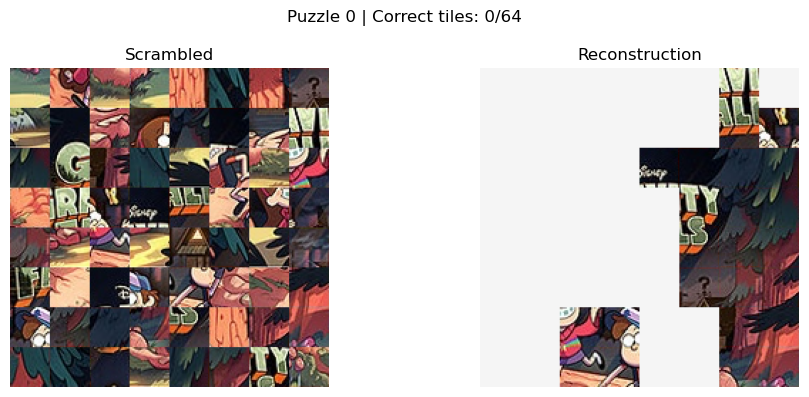

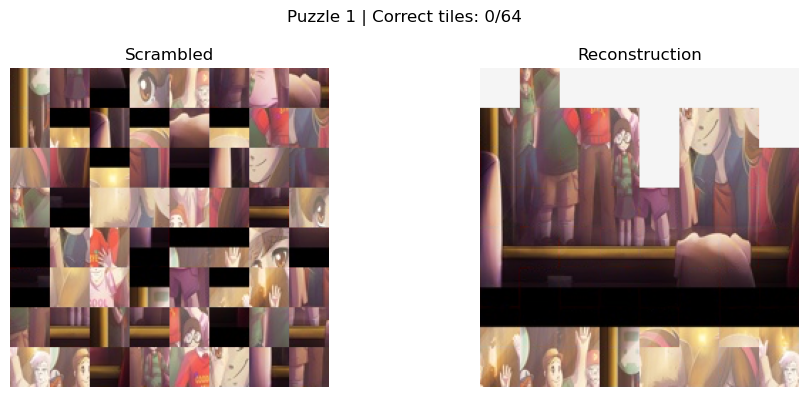

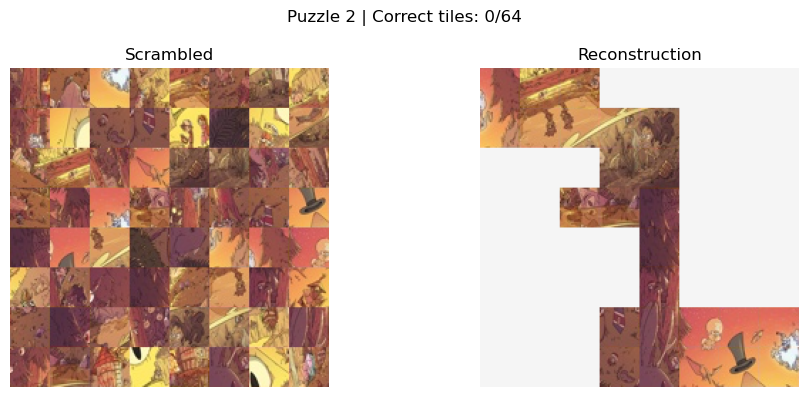

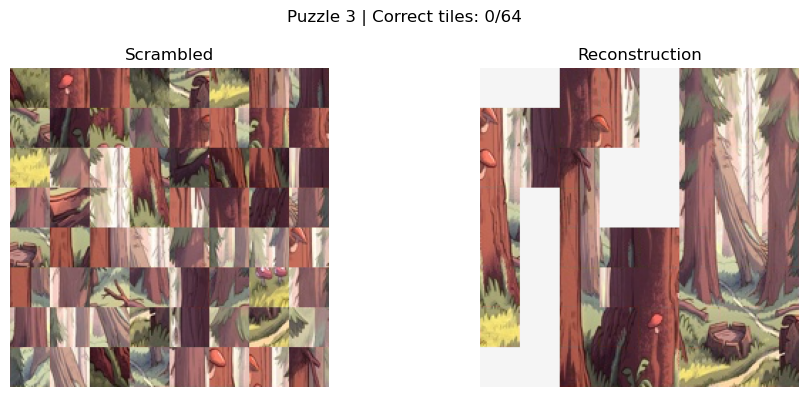

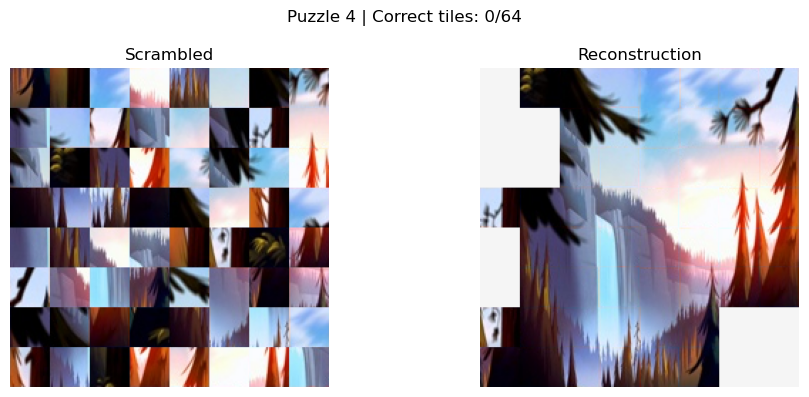


TILE ACCURACY: 13/7040 (0.18%)


In [8]:
# =========================================================
# 1. SETUP & IMPORTS
# =========================================================
import cv2
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import random

# =========================================================
# PATH SETUP
# =========================================================
BASE_DIR = r"C:\Term 5\image_project\OneDrive_2025-11-26\Jigsaw Puzzle Dataset"

PUZZLE_DIR = os.path.join(BASE_DIR, "Gravity Falls", "puzzle_8x8")   # .jpg
GT_DIR     = os.path.join(BASE_DIR, "Gravity Falls", "correct")      # .png
OUT_DIR    = os.path.join(BASE_DIR, "results", "8x8_demo")

os.makedirs(OUT_DIR, exist_ok=True)

GRID_SIZE = 8
VIS_LIMIT = 5   # visualize ONLY first 5 puzzles

# =========================================================
# 2. PUZZLE GROUP
# =========================================================
class PuzzleGroup:
    def __init__(self, pid):
        self.placements = {(0,0): pid}
        self.min_r = self.max_r = 0
        self.min_c = self.max_c = 0

    def size(self):
        return len(self.placements)

    def can_merge(self, other, dr, dc):
        for (r,c) in other.placements:
            if (r+dr, c+dc) in self.placements:
                return False
        return True

    def merge(self, other, dr, dc):
        for (r,c), pid in other.placements.items():
            self.placements[(r+dr, c+dc)] = pid

        self.min_r = min(self.min_r, min(r+dr for r,_ in other.placements))
        self.min_c = min(self.min_c, min(c+dc for _,c in other.placements))
        self.max_r = max(self.max_r, max(r+dr for r,_ in other.placements))
        self.max_c = max(self.max_c, max(c+dc for _,c in other.placements))

# =========================================================
# 3. SAFE RENDERING
# =========================================================
def render_current_state(groups, pieces, h, w):
    canvas = np.full((GRID_SIZE*h, GRID_SIZE*w, 3), 245, dtype=np.uint8)
    if not groups:
        return canvas

    main = max(groups.values(), key=lambda g: g.size())
    shift_r, shift_c = -main.min_r, -main.min_c

    for (r,c), pid in main.placements.items():
        rr, cc = r + shift_r, c + shift_c
        if 0 <= rr < GRID_SIZE and 0 <= cc < GRID_SIZE:
            canvas[rr*h:(rr+1)*h, cc*w:(cc+1)*w] = pieces[pid]

    return canvas

# =========================================================
# 4. SOLVER WITH HISTORY
# =========================================================
def solve_with_history_8x8(pieces):
    history = []
    h, w, _ = pieces[0].shape
    n = len(pieces)

    # Snapshot 1: Scrambled
    canvas = np.zeros((GRID_SIZE*h, GRID_SIZE*w, 3), dtype=np.uint8)
    for i,p in enumerate(pieces):
        r,c = divmod(i, GRID_SIZE)
        canvas[r*h:(r+1)*h, c*w:(c+1)*w] = p
    history.append(("Scrambled", canvas))

    lab = [cv2.cvtColor(p, cv2.COLOR_RGB2LAB).astype(np.float32) for p in pieces]
    R = np.array([p[:,-1,:] for p in lab])
    L = np.array([p[:,0,:]  for p in lab])
    B = np.array([p[-1,:,:] for p in lab])
    T = np.array([p[0,:,:]  for p in lab])

    H = np.full((n,n), np.inf)
    V = np.full((n,n), np.inf)

    for i in range(n):
        for j in range(n):
            if i != j:
                H[i,j] = np.mean((R[i]-L[j])**2)
                V[i,j] = np.mean((B[i]-T[j])**2)

    edges = []
    for i in range(n):
        for j in range(n):
            if i != j:
                edges.append((H[i,j], i, j, 0))
                edges.append((V[i,j], i, j, 1))
    edges.sort(key=lambda x: x[0])

    groups = {i: PuzzleGroup(i) for i in range(n)}
    lookup = {i:i for i in range(n)}

    for _,u,v,rel in edges:
        gu, gv = lookup[u], lookup[v]
        if gu == gv:
            continue

        g1, g2 = groups[gu], groups[gv]
        (r1,c1) = next(k for k,vv in g1.placements.items() if vv == u)
        (r2,c2) = next(k for k,vv in g2.placements.items() if vv == v)

        dr, dc = (0,1) if rel == 0 else (1,0)

        if g1.can_merge(g2, r1+dr-r2, c1+dc-c2):
            g1.merge(g2, r1+dr-r2, c1+dc-c2)
            for pid in g2.placements.values():
                lookup[pid] = gu
            del groups[gv]

    final_img = render_current_state(groups, pieces, h, w)
    history.append(("Reconstruction", final_img))

    return history, final_img

# =========================================================
# 5. TILE-BASED ACCURACY
# =========================================================
def tile_accuracy(pred, gt):
    h, w, _ = pred.shape
    th, tw = h // GRID_SIZE, w // GRID_SIZE

    correct_tiles = 0

    for r in range(GRID_SIZE):
        for c in range(GRID_SIZE):
            p_tile = pred[r*th:(r+1)*th, c*tw:(c+1)*tw]
            g_tile = gt[r*th:(r+1)*th, c*tw:(c+1)*tw]

            if np.mean((p_tile.astype(np.float32) - g_tile.astype(np.float32))**2) < 5:
                correct_tiles += 1

    return correct_tiles

# =========================================================
# 6. RUN + ACCURACY + LIMITED VIS
# =========================================================
image_paths = sorted(
    glob.glob(os.path.join(PUZZLE_DIR, "*.jpg")),
    key=lambda x: int(os.path.basename(x).split('.')[0])
)

total_tiles = 0
correct_tiles = 0

print("\n--- 8x8 JIGSAW SOLVER (TILE ACCURACY) ---\n")

for idx, path in enumerate(image_paths):
    base = os.path.splitext(os.path.basename(path))[0]

    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

    pieces = [
        img[i*(img.shape[0]//8):(i+1)*(img.shape[0]//8),
            j*(img.shape[1]//8):(j+1)*(img.shape[1]//8)]
        for i in range(8) for j in range(8)
    ]

    random.shuffle(pieces)
    steps, final_img = solve_with_history_8x8(pieces)

    gt = cv2.imread(os.path.join(GT_DIR, base + ".png"))
    gt = cv2.cvtColor(gt, cv2.COLOR_BGR2RGB)

    ct = tile_accuracy(final_img, gt)
    correct_tiles += ct
    total_tiles += GRID_SIZE * GRID_SIZE

    # -------- VISUALIZE ONLY FIRST 5 --------
    if idx < VIS_LIMIT:
        fig, axes = plt.subplots(1, 2, figsize=(10,4))
        fig.suptitle(f"Puzzle {base} | Correct tiles: {ct}/64", fontsize=12)

        for ax, (title, imgx) in zip(axes, steps):
            ax.imshow(imgx)
            ax.set_title(title)
            ax.axis("off")

        plt.tight_layout()
        plt.savefig(os.path.join(OUT_DIR, f"{base}_demo.png"), dpi=150)
        plt.show()

accuracy = 100 * correct_tiles / total_tiles
print(f"\nTILE ACCURACY: {correct_tiles}/{total_tiles} ({accuracy:.2f}%)")
